In [6]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)

## `https://www.kaggle.com/snap/amazon-fine-food-reviews 파일 사용
https://wikidocs.net/72820

In [7]:

# Reviews.csv 파일을 data라는 이름의 데이터프레임에 저장. 단, 10만개의 행(rows)으로 제한.
data = pd.read_csv("Reviews.csv", nrows = 100000)
print('전체 리뷰 개수 :',(len(data)))

전체 리뷰 개수 : 100000


In [8]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
data = data[['Text','Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [10]:
# 랜덤으로 10개의 샘플 출력
data.sample(10)

,Text,Summary
3582,"I rarely eat anything but whole wheat pasta, b...",reminds me of Italy
60498,I absolutely love 5-hour ENERGY! I use it afte...,5-hour ENERGY Highly Recommend!
53227,"this chocolate is a true treat to eat, perfect...",supreme chocolate
21333,Greenies are very muched loved as a tatsy Trea...,Excellent Teeth Cleaner
3885,I love these noodles. They are really great f...,Great and good price!
51521,These are great! As a lover of all chips I'm s...,"Delicious, just like Salt and Vinegar Chips!"
84261,Like other customers I divide these into handf...,"Great snack, great value"
10685,I recommend this instead for the same price: <...,"It's ok, but certainly not worth the cost"
59948,"The noodles were all very broken, but the tast...",Knorr's beef noodles
41032,"Despite claiming they use the ""finest ingredie...",HORRIBLE INGREDIENTS


In [11]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [12]:
# text 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['Text'], inplace=True)
print("전체 샘플수 :", len(data))

전체 샘플수 : 88426


In [13]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [14]:
# Null 값을 가진 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88425


In [15]:
# 전처리 함수 내 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [16]:
# NLTK의 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{"haven't", 'yourselves', "couldn't", 'before', 'was', "didn't", 'doing', 'then', 'up', 'haven', 'wouldn', "aren't", 'a', 'your', "mustn't", 'their', 'whom', 'herself', 'after', 'some', 'now', 'theirs', 'down', 'both', 'had', 'couldn', 'that', 'until', "you're", 'with', 'were', 'at', 'when', 'through', "won't", 'below', 'under', 'where', "needn't", 'be', 'been', 'between', 'y', 'most', 'i', 'once', 'he', 'is', 'few', 'them', "hadn't", "you'll", 'how', 'again', 'being', "you'd", 'which', "don't", 'isn', 'ourselves', 'themselves', 'than', 'out', 'on', 'why', 'having', 'will', "doesn't", 'and', 'further', 'all', 'hers', "weren't", 'for', 'her', 'the', 'should', "you've", 'same', 'does', 'don', "hasn't", 'me', 'did', 'hasn', 'against', 'above', 'if', 'off', "wasn't", 'won', 'm', 'each', 'aren', 'such', 't', 's', 'of', "shouldn't", 'doesn', 'not', 'about', 'wasn', 'there', 'didn', 'an', 'these', 'no', 'what', 'nor', 'weren', 'his', 'or', 'by', 'during', 'ain', "mightn't", 'its'

In [17]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [18]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [19]:
# Text 열 전처리
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

C:\Users\98083\anaconda3\envs\suwah\lib\site-packages\bs4\__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [20]:
# Summary 열 전처리
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

C:\Users\98083\anaconda3\envs\suwah\lib\site-packages\bs4\__init__.py:408: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [21]:
data['Text'] = clean_text
data['Summary'] = clean_summary

In [22]:
# 길이가 공백인 샘플은 NULL 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


In [23]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88355


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


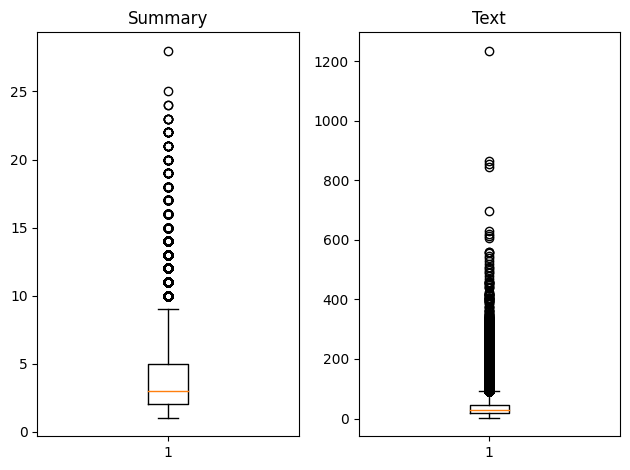

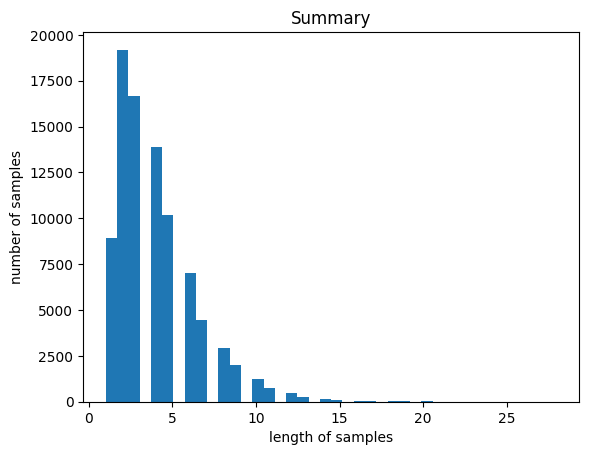

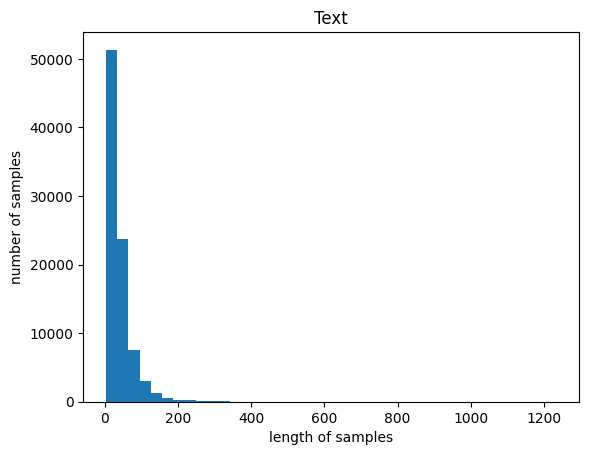

In [24]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
text_max_len = 50
summary_max_len = 8

In [26]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [27]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859


In [28]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [29]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 65818


In [30]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [31]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [32]:
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [33]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[61165 60938 37145 ... 45440 26023  1298]


In [34]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [35]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 13163


In [36]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [37]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [38]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31987
등장 빈도가 6번 이하인 희귀 단어의 수: 23700
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8287
단어 집합에서 희귀 단어의 비율: 74.09260011879826
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.383968496474902


In [39]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [40]:
print(encoder_input_train[:3])

[[632, 179, 39, 1, 4640, 1303, 70, 1393, 7, 57, 980, 414, 361, 20, 447, 255, 54, 7683, 1241, 385, 298, 1772, 147, 39, 3, 49, 4388, 108], [4, 489, 206, 446, 91, 583, 100, 2009, 611, 867, 2202, 138, 2766, 334, 2202, 7, 4523, 871, 54, 446, 138, 55, 208, 611, 2009, 2708, 2766, 33, 446, 35, 2766, 2009, 618, 98, 9, 3147, 2767, 75, 100, 4054], [143, 93, 514, 123, 525, 197, 96, 190, 338, 856, 223, 71, 21, 5086, 394, 394, 239, 15, 531, 197]]


In [41]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [42]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10524
등장 빈도가 5번 이하인 희귀 단어의 수: 8150
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2374
단어 집합에서 희귀 단어의 비율: 77.44203724819461
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.940836959469056


In [43]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [44]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [45]:
print(decoder_input_train[:5])

[[1, 130, 15], [1, 15, 19, 240], [1, 51, 63, 385, 319, 118], [1, 397, 948], [1, 29, 122]]


In [46]:
print(decoder_target_train[:5])

[[130, 15, 2], [15, 19, 240, 2], [51, 63, 385, 319, 118, 2], [397, 948, 2], [29, 122, 2]]


In [47]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [48]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 1310
삭제할 테스트 데이터의 개수 : 292


In [49]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 51345
훈련 레이블의 개수 : 51345
테스트 데이터의 개수 : 12871
테스트 레이블의 개수 : 12871


C:\Users\98083\anaconda3\envs\suwah\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [50]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

In [51]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [52]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [53]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [54]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [57]:
from attention import AttentionLayer

In [58]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [65]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [66]:
# #조기종료
# """
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
# history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
#           validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
#           batch_size = 256, callbacks=[es], epochs = 50)
#           """

In [67]:
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()

In [68]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [69]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [70]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [71]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [72]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [73]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    sentence=''
    for i in input_seq:
        if(i!=0):
            sentence = sentence + src_index_to_word[i]+' '
    return sentence

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    sentence=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            sentence = sentence + tar_index_to_word[i] + ' '
    return sentence

In [74]:
for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  husband absolutely love gum actually good keeps flavor long time 
실제 요약문 : awesome 
1/1 [==============================] - 0s 34ms/step
예측 요약문 :  salmon plain san pretzel almond everything favorite


원문 :  love able get food go england get good price heinz salad cream original ounce squeeze bottle 
실제 요약문 : heinz salad cream 
1/1 [==============================] - 0s 31ms/step
예측 요약문 :  salmon plain san pretzel mallomars costco preserves


원문 :  almost say much sugar appropriate description fresh brand indian sweets products ordered varieties product presentation appealing indeed products contain unwanted chemicals preservatives use sugar cheap compensate missing ingredients say least disappointed product offerings buy products convince reduced sugar content sweets line excellent packaging prompt shipping 
실제 요약문 : too sweet 
1/1 [==============================] - 0s 35ms/step
예측 요약문 :  per grow lady plate plate subscribe subscribe


원문 :  bought bought bowl pop white hull less p

1/1 [==============================] - 0s 33ms/step
예측 요약문 :  salmon plain leaking sent mallomars sent mallomars


원문 :  absolutely love chocolate taste like german chocolate cake bite high therefore make great pre munch even training gave blonde boyfriend gift likes better empty tins used containers got love crown design actually look pretty nice placed dressing table 
실제 요약문 : love the chocolate 
1/1 [==============================] - 0s 52ms/step
예측 요약문 :  side zing bottles sent lousy previous yourself


원문 :  know reviewer talking like oranges absolute best ever tasted 
실제 요약문 : the absolute best 
1/1 [==============================] - 0s 41ms/step
예측 요약문 :  salmon plain san pretzel mallomars spicey twinings


원문 :  thought flavor good tasted like real cup coffee like one brewed french roast strong almost little bitter prefer san francisco bay cup style plastic cup trying lighter roast 
실제 요약문 : good but soooo strong 
1/1 [==============================] - 0s 51ms/step
예측 요약문 :  sa

예측 요약문 :  salmon plain san pretzel mallomars spicey twinings


원문 :  cinnamon clove spices feel like drinking hot apple pie cold fall day really enjoy lipton chai tea aroma pleasant flavor smooth sweet excellent chai tea company 
실제 요약문 : taste of fall 
1/1 [==============================] - 0s 44ms/step
예측 요약문 :  salmon find lasting lasting lasting recommended lasting


원문 :  read web site hcg hard find ingredients salad dressing sugars added husband usually uses packaged dry mix really liked instead regular mix use oil tastes great 
실제 요약문 : great product 
1/1 [==============================] - 0s 75ms/step
예측 요약문 :  salmon plain leaking sent mallomars mallomars joy


원문 :  like ever knew brand asked greek coffee appeared stuff great authentic find greek imports store even price great stuff know equivalent hunting use espresso machine get caffeine fix least kick price point maintenance travel 
실제 요약문 : just like my mom makes 
1/1 [==============================] - 0s 62ms/step
예측 요약문

1/1 [==============================] - 0s 70ms/step
예측 요약문 :  salmon plain costco granola would banana definitely


원문 :  golden get picky eating priority worried training going anxious eat training treats well eat great full however best smell purchasing 
실제 요약문 : golden loves them 
1/1 [==============================] - 0s 53ms/step
예측 요약문 :  salmon plain real mallomars costco preserves lemonade


원문 :  used bittersweet sauce homemade cafe mochas number years tried many powders etc nothing compares flavor thoroughly chocolate without excessive sweetness milk chocolate etc people add little sugar bittersweet sweet enough 
실제 요약문 : makes the best cafe mocha ever 
1/1 [==============================] - 0s 49ms/step
예측 요약문 :  salmon plain irish feeling square square shipment


원문 :  love tea much easier use tea bags definitely buy run 
실제 요약문 : very good product 
1/1 [==============================] - 0s 37ms/step
예측 요약문 :  salmon plain real send cappuccino cappuccino cappuccino


원문 :  

1/1 [==============================] - 0s 61ms/step
예측 요약문 :  salmon plain real pretzel mallomars costco boring


원문 :  mother load canned clams juice cups cups chopped clams found sand able use every last drop juices simply recipe best white clam sauce ever made 
실제 요약문 : white clam sauce 
1/1 [==============================] - 0s 42ms/step
예측 요약문 :  salmon plain pretzel costco bomb lemonade small


원문 :  really like taste san francisco breakfast blend tend leave thicker last swallow bottom cup though works us continue buy 
실제 요약문 : sf bay cup 
1/1 [==============================] - 0s 35ms/step
예측 요약문 :  salmon plain real uses send chocolatey dents


원문 :  tried bones local stores charge times much even add shipping need understand puppies years old bones perfect size last much longer plain rawhide suggest dogs like chew even maybe ones might surprised might like 
실제 요약문 : my puppies love them 
1/1 [==============================] - 0s 36ms/step
예측 요약문 :  salmon plain real mallomars 

1/1 [==============================] - 0s 45ms/step
예측 요약문 :  salmon plain real send cappuccino cappuccino cappuccino


원문 :  started ordering yummy rich chocolate cookies months ago chocolate lovers know worth eat poor quality chocolate filled dark chocolate bits soft creamy mouth actually good eating one truly satisfying 
실제 요약문 : brownie style soft cookie 
1/1 [==============================] - 0s 34ms/step
예측 요약문 :  salmon plain sent mallomars mallomars preserves ages


원문 :  guess dogs love may told previous reviewer easy mold food product around pills capsules even large pills dogs loved eagerly took supplements much cheaper easier work pill pockets heartily recommend giving try turning second order today six pomeranians five stars 
실제 요약문 : flavor worked for me 
1/1 [==============================] - 0s 35ms/step
예측 요약문 :  salmon herbal canned pig addicting powerful mallomars


원문 :  got new keurig looking great drink still looking fair best watery nothing brag 
실제 요약문 : nothing

1/1 [==============================] - 0s 32ms/step
예측 요약문 :  salmon plain leaking sent mallomars nutty joy


원문 :  cake mix things cake moist soft finely textured delicious one complaint made would sweet personal taste nobody else thought way bought son gave gluten eaters said could tell difference wanted eat makes winner book 
실제 요약문 : winner 
1/1 [==============================] - 0s 33ms/step
예측 요약문 :  salmon plain sent spot spot promised cookies


원문 :  soft coated terrier loves treats healthy eat pretty quickly long term entertainment activity 
실제 요약문 : sam are yummy 
1/1 [==============================] - 0s 33ms/step
예측 요약문 :  salmon plain san pretzel mallomars costco preserves


원문 :  cannot find caviar anywhere two hour found caviar amazon figured got house apprehensive open bad experiences mail order foods perfect salty makes special dinner even looking something special holiday meals order prepare blow taste buds price seal approval 
실제 요약문 : great for the price 
1/1 [=====

1/1 [==============================] - 0s 35ms/step
예측 요약문 :  salmon plain leaking sent mallomars mallomars walmart


원문 :  three month old westie loves treat bad thing huge training sit takes seconds finish eating next trick recommend breaking tiny pieces label says day pup loves treat would anything 
실제 요약문 : woof woof 
1/1 [==============================] - 0s 38ms/step
예측 요약문 :  salmon plain leaking sent mallomars mallomars packaged


원문 :  alternate seasoning grandma poultry delicious pair pantry keeps wife kids thinking one bird boy 
실제 요약문 : your chicken is awesome 
1/1 [==============================] - 0s 36ms/step
예측 요약문 :  salmon plain real send cappuccino cappuccino cappuccino


원문 :  unfamiliar miso find know assured best using small amount better large amount add end mixing bit water dissolve even add let stand 
실제 요약문 : it is the real thing 
1/1 [==============================] - 0s 54ms/step
예측 요약문 :  salmon plain costco granola stomach assortment might


원문 :  usually 

1/1 [==============================] - 0s 33ms/step
예측 요약문 :  salmon plain sent spot spot promised cookies


원문 :  love coffee better others pricy cannot find anywhere else worth price 
실제 요약문 : great coffee 
1/1 [==============================] - 0s 34ms/step
예측 요약문 :  salmon plain san pretzel pup pup basic


원문 :  stuff delicious substituted perfectly recipes used definitely react cane beet sugars made awesome coconut ever danger want make many goodies though 
실제 요약문 : yum 
1/1 [==============================] - 0s 37ms/step
예측 요약문 :  salmon plain pretzel mallomars costco preserves bomb


원문 :  love baking soda used sorts things around house arm hammer one best baking soda brands 
실제 요약문 : so many uses 
1/1 [==============================] - 0s 36ms/step
예측 요약문 :  salmon plain san pretzel mallomars spicey bargain


원문 :  edit comment gave comment cereal really good first like taste loved boxes lasted days ate much ha ha plan ezekiel flax seed cereals arrive try eat lot 
실제 요약문 : does

1/1 [==============================] - 0s 36ms/step
예측 요약문 :  salmon plain san pretzel mallomars spicey orange


원문 :  love tea tried initially friend home instantly loved tea delicious boring raspberry tea flavor much complex even trying oz week friends refer raspberry crack tea especially love tea tastes great hot iced teas taste right ways 
실제 요약문 : raspberry crack tea 
1/1 [==============================] - 0s 41ms/step
예측 요약문 :  salmon find costco bomb grocery grocery potato


원문 :  got great flavor sweet find refreshing love flavors 
실제 요약문 : refreshing 
1/1 [==============================] - 0s 36ms/step
예측 요약문 :  salmon plain san pretzel mallomars spicey bargain


원문 :  husband favorite cup bold smooth flavor price right bitter aftertaste starbucks coffee tastes like high quality coffee 
실제 요약문 : hubby favorite coffee 
1/1 [==============================] - 0s 50ms/step
예측 요약문 :  salmon plain costco granola would banana definitely


원문 :  picked tin want chips feeling adventuro

1/1 [==============================] - 0s 36ms/step
예측 요약문 :  salmon plain leaking sent mallomars mallomars joy


원문 :  really love oatmeal raisin cookies ordered pamela really bad dry tasteless seemed old going back pamela oatmeal raisin find 
실제 요약문 : dry and awful 
1/1 [==============================] - 0s 49ms/step
예측 요약문 :  salmon plain san pretzel mallomars costco preserves


원문 :  good coffe good value tried others stick one tried others stuck one 
실제 요약문 : good 
1/1 [==============================] - 0s 38ms/step
예측 요약문 :  salmon plain real send cappuccino cappuccino pizza


원문 :  using soap years loving dr even commented soft healthy previous problem skin hair problems dry spending fortune different products one day washed soap one bar hair one washing hair shinier ever totally gone moisture returned save money buying products one 
실제 요약문 : great for hair too 
1/1 [==============================] - 0s 37ms/step
예측 요약문 :  lasting lasting lasting recommended yogi yogi twinings



1/1 [==============================] - 0s 49ms/step
예측 요약문 :  say bear oat easily oat easily restaurant


원문 :  tried couple gum one unusual perfect want something different flavor lasts long enough love fact think go get piece 
실제 요약문 : no 
1/1 [==============================] - 0s 36ms/step
예측 요약문 :  salmon plain real would extra now crazy


원문 :  organic dark chocolate currants hazelnuts fantastic wish hazelnuts chopped fine nuts little bigger would perfect 
실제 요약문 : the greatest chocolate 
1/1 [==============================] - 0s 54ms/step
예측 요약문 :  salmon plain real would powerful jug stomach


원문 :  product great definitely think several people would love item delivered doorstep yummy 
실제 요약문 : very yummy item 
1/1 [==============================] - 0s 39ms/step
예측 요약문 :  salmon plain real send cappuccino cappuccino cappuccino


원문 :  staple many asian recipes tip add teaspoon instant noodle bring broth life companion years living dorm room 
실제 요약문 : great to have in any kitchen

1/1 [==============================] - 0s 36ms/step
예측 요약문 :  say subscription workout containers smoothies wife overly


원문 :  good product makes anything salt vinegar without popcorn outstanding thinking buying bulk life would empty without stuff 
실제 요약문 : as advertised 
1/1 [==============================] - 0s 50ms/step
예측 요약문 :  salmon plain real uses costco swedish hearty


원문 :  fabulous product great baking snacking never ever go back using little square caramels wrapped plastic trying 
실제 요약문 : this is great product 
1/1 [==============================] - 0s 40ms/step
예측 요약문 :  salmon plain san pretzel mallomars spicey bargain


원문 :  orange mango ice delicious carbonated beverage ever made sucralose trust safer artificial sweeteners whole family including kids age six love 
실제 요약문 : cannot get enough 
1/1 [==============================] - 0s 36ms/step
예측 요약문 :  salmon plain san pretzel mallomars costco preserves


원문 :  first couple bags great really fresh smooth great taste

1/1 [==============================] - 0s 34ms/step
예측 요약문 :  salmon plain sent spot spot promised cookies


원문 :  words come mind amazing wonderful delicious fantastic delightful thank snyder pieces bravo next best thing actual buffalo chicken wing 
실제 요약문 : get some 
1/1 [==============================] - 0s 35ms/step
예측 요약문 :  salmon plain real send cappuccino cappuccino pizza


원문 :  product best two ordering coconut palm sugar buy regular sugar anymore amazon new shopping tool products received company stated day arrival thanks 
실제 요약문 : amazon does it again 
1/1 [==============================] - 0s 51ms/step
예측 요약문 :  salmon plain real mallomars salmon costco dressing


원문 :  great taste medicinal candy found berry farm reorder amazon seem dislike taste find refreshing read claims herbal tea ordered seeds grow herbs grow wild abundance america recommend try something different traditional 
실제 요약문 : great taste and traditional medicine 
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 34ms/step
예측 요약문 :  salmon plain san pretzel mallomars spicey orange


원문 :  angry birds gummies rock well packaged great tasting big portions kids go wild sell quick stores glad mail order option 
실제 요약문 : best by 
1/1 [==============================] - 0s 140ms/step
예측 요약문 :  salmon plain san pretzel mallomars costco preserves


원문 :  ordered thought would freeze dried strawberries could use cereal snacking somewhat dehydrated strawberries super sweetened use baking instead aware plain dried strawberries 
실제 요약문 : not really dried 
1/1 [==============================] - 0s 34ms/step
예측 요약문 :  salmon plain leaking rubber real run good


원문 :  mom used love eat jelly beans live miles away us giving jelly belly trip memory lane 
실제 요약문 : belly birthday 
1/1 [==============================] - 0s 48ms/step
예측 요약문 :  salmon plain costco granola stomach stomach kitchen


원문 :  service extremely fast efficient tea exactly looking first taste exactly 

1/1 [==============================] - 0s 54ms/step
예측 요약문 :  salmon plain sent mallomars addiction child pay


원문 :  dog loves food cans dented top making harder open still worth effort considering price quality 
실제 요약문 : good dog food but 
1/1 [==============================] - 0s 39ms/step
예측 요약문 :  salmon plain real uses costco highly stomach


원문 :  wow virtually newman products best tried every brand including number organic chocolates beats naturally subjective would suggest blind tasting newman chocolate would always near top every list favor get good regret 
실제 요약문 : could not be better 
1/1 [==============================] - 0s 57ms/step
예측 요약문 :  salmon plain real extra college yr yr


원문 :  thick coarse hair product give results like hair soft became almost sticky could barely run fingers hair sticking however worked great sister perhaps hair type problem 
실제 요약문 : not for me 
1/1 [==============================] - 0s 43ms/step
예측 요약문 :  salmon plain costco granola stomach 

1/1 [==============================] - 0s 52ms/step
예측 요약문 :  salmon plain costco bomb cold life organic


원문 :  looked high low natural gum liked finally found vanilla mint nice texture consistency nice flavor lasts subtle flavor overpowering 
실제 요약문 : yummy all natural gum 
1/1 [==============================] - 0s 35ms/step
예측 요약문 :  salmon plain costco granola would banana definitely


원문 :  little guys favorite loves rabbit flavor living middle dont local places high quality foods terrier excellent product right size small dogs purchased varity pack online let choose product liked best 
실제 요약문 : is are little favorite 
1/1 [==============================] - 0s 42ms/step
예측 요약문 :  salmon plain real lover mallomars every mallomars


원문 :  tea premium accept green tea bags less tasty probably less healthy medical conditions drinking green tea helpful cancer arthritis high cholesterol levels disease infection immune function acne omg drink four cups day ultimate tea benefits 
실제 요약문 :

1/1 [==============================] - 0s 41ms/step
예측 요약문 :  say subscription guilt can dessert elsewhere dieters


원문 :  teriyaki flavor fish jerky good hiking sometimes take bag jerky water fruit day one bag calories fat sugar protein three flavors best stores sells like bag seems like lot 
실제 요약문 : great tasting stuff but price maybe too high 
1/1 [==============================] - 0s 42ms/step
예측 요약문 :  salmon plain real mallomars costco preserves lemonade


원문 :  love product soft melt mouth popcorn teeth us past certain age would love convenience purchasing via amazon price shipping charge understand price bag 
실제 요약문 : fantastic product but overpriced here 
1/1 [==============================] - 0s 70ms/step
예측 요약문 :  salmon plain real mallomars costco preserves lemonade


원문 :  received tassimo coffee machine christmas enjoying taste wonderful disc wife really enjoys lattes convenient way enjoy one 
실제 요약문 : gevalia discs 
1/1 [==============================] - 0s 38ms/step
예측

1/1 [==============================] - 0s 34ms/step
예측 요약문 :  salmon plain sent spot spot promised promised


원문 :  price product nothing beat good quality beef consistant flavor texture buy soon 
실제 요약문 : great product 
1/1 [==============================] - 0s 35ms/step
예측 요약문 :  salmon plain san pretzel mallomars costco preserves


원문 :  cup coffee writing review deal made buy tully blend think tully make best kcups though love kona blend quite expensive nice flavor could bit stronger said get another deal blend definately 
실제 요약문 : like it 
1/1 [==============================] - 0s 36ms/step
예측 요약문 :  salmon plain sent mallomars preserves close gravy


원문 :  love using great mixed little vodka creates metallic looking color royal icing fondant royal icing make sure dried hours paint pit one note work well chocolate silver dust covered nicely gold look right could get thick enough look like gold 
실제 요약문 : wonderful stuff 
1/1 [==============================] - 0s 35ms/step
예측 요약문 : 

1/1 [==============================] - 0s 35ms/step
예측 요약문 :  salmon plain real pretzel mallomars costco preserves


원문 :  first bought another brand coconut butter found liking every way hoping brands different tried disappointed find texture coarse dry dried coconut meat processed blender softness coconut brand much trying another brand stick first one bought 
실제 요약문 : disappointing after tasting another brand 
1/1 [==============================] - 0s 36ms/step
예측 요약문 :  ones containers ones ones finger ugh ugh


원문 :  turned healthy label cookies actually taste good 
실제 요약문 : delicious 
1/1 [==============================] - 0s 34ms/step
예측 요약문 :  salmon plain san pretzel pup pup overly


원문 :  almonds chocolate love well dipped chocolate almonds baked chocolate flavor baked chocolate flavor provides mess baked flavor kind gives burnt flavor almonds alright little disappointed also get lightly sweet flavor sucralose think provides fake kind sweetness flavor overall really love almo

1/1 [==============================] - 0s 35ms/step
예측 요약문 :  salmon plain san pretzel mallomars spicey bargain


원문 :  daughter saw try said oh switch apparently school answer soda really liked product small calorie content similar amount soda one carbonated beverage added sugar vitamin benefits well sweet flavor strong normally strawberry kiwi favorite flavor combination glad tried would definitely try 
실제 요약문 : delicious 
1/1 [==============================] - 0s 36ms/step
예측 요약문 :  salmon concept mild thank average sent spot


원문 :  salty like regular supermarket chips snack overwhelm guilt gotta chips kettle chips lightly salted chips searching cholesterol trans fats artificial anything manufacturing process actually seem kind home made quality excellent product 
실제 요약문 : crunch wow 
1/1 [==============================] - 0s 38ms/step
예측 요약문 :  salmon plain sent mallomars mallomars every sent


원문 :  absolutely husband love however another customer put expensive ship cost shipping

1/1 [==============================] - 0s 37ms/step
예측 요약문 :  salmon plain real would extra vendor vendor


원문 :  wanted add flavor hot drinks find way put tiny amounts drinks cannot even use full drop white coffee white chocolate ml cinnamon oil fantastic 
실제 요약문 : perfect 
1/1 [==============================] - 0s 35ms/step
예측 요약문 :  salmon plain pretzel mallomars costco preserves bomb


원문 :  bought product made usa small dogs used breaking giving pieces breast strips large mouths hard neither husband break order amazon verified purchase 
실제 요약문 : dog jerky 
1/1 [==============================] - 0s 37ms/step
예측 요약문 :  salmon plain irish dents sostoken long toffee


원문 :  picked today thought would try since baby pretty good lot apple flavor nice texture enjoyed plan purchase use great snack 
실제 요약문 : good for snack 
1/1 [==============================] - 0s 35ms/step
예측 요약문 :  salmon plain leaking sent mallomars nutty ketchup


원문 :  one best flavored coffees tried usually like fla

1/1 [==============================] - 0s 37ms/step
예측 요약문 :  small chocolatey that previous old avoid hormel


원문 :  never problems food dog seems like pretty expensive though 
실제 요약문 : great food kind of expensive 
1/1 [==============================] - 0s 35ms/step
예측 요약문 :  salmon plain real send cappuccino cappuccino cappuccino


원문 :  simply best cookies ever kids love love much healthier cookie brands could recommend 
실제 요약문 : the best cookies ever 
1/1 [==============================] - 0s 38ms/step
예측 요약문 :  salmon plain san pretzel mallomars spicey bargain


원문 :  best dipping oil ever local store quit carrying happy found ordered bottles 
실제 요약문 : the best in the world 
1/1 [==============================] - 0s 34ms/step
예측 요약문 :  salmon plain real send cappuccino cappuccino cappuccino


원문 :  tea delicious mean perfect drink long work day truely relaxing put right sleep 
실제 요약문 : delicious relaxing 
1/1 [==============================] - 0s 57ms/step
예측 요약문 :  salmon plain 

1/1 [==============================] - 0s 49ms/step
예측 요약문 :  salmon plain san pretzel mallomars spicey bargain


원문 :  description says tray one package priced three times much store take time today send back 
실제 요약문 : not tray of 
1/1 [==============================] - 0s 38ms/step
예측 요약문 :  salmon plain san pretzel mallomars spicey twinings


원문 :  love coconut juice love also mention love pina though understand pina made coconut milk coconut juice thought would first drink strange salty flavor secondly sweet smells sweet pineapple flavors match smell 
실제 요약문 : weird salty sour flavor 
1/1 [==============================] - 0s 40ms/step
예측 요약문 :  salmon plain sent mallomars pay yourself sugar


원문 :  lot candy reasonable price boys older still love pez great find buy enjoy 
실제 요약문 : pez do you need to say any more 
1/1 [==============================] - 0s 43ms/step
예측 요약문 :  salmon plain san pretzel mallomars spicey twinings


원문 :  bit nervous ordering product due fact high hopes 

1/1 [==============================] - 0s 41ms/step
예측 요약문 :  salmon plain real pretzel mallomars costco mallomars


원문 :  great soft fresh possibly freshest tootsie rolls ever seems way get long thin size well liked much ordered 
실제 요약문 : extremely fresh 
1/1 [==============================] - 0s 41ms/step
예측 요약문 :  salmon plain real send cappuccino cappuccino cappuccino


원문 :  love pie made brand mincemeat condensed kind year local stores carry condensed packaged type like jars find soupy went line found could purchase way ordered got quickly know stores carry next fall get 
실제 요약문 : for delicious pie 
1/1 [==============================] - 0s 45ms/step
예측 요약문 :  salmon plain sent mallomars mallomars preserves ages


원문 :  works good blender shakes ice find decaf stores add flavors spices taste good nutrition 
실제 요약문 : decaf 
1/1 [==============================] - 0s 38ms/step
예측 요약문 :  salmon plain san pretzel mallomars spicey bargain


원문 :  tried kraft velveeta chicken broccoli s

1/1 [==============================] - 0s 51ms/step
예측 요약문 :  salmon plain uses dents sugar uses everyone


원문 :  sent grandmother th birthday loves chocolate kisses happy big surprise unique item give gift highly recommended 
실제 요약문 : great gift 
1/1 [==============================] - 0s 51ms/step
예측 요약문 :  salmon plain san pretzel mallomars costco preserves


원문 :  sold product great cats really yr old cat keep vet feels unknown source grains may continue vomit food cat real old like mine suggest trying grain free food cats carnivores grains fillers types foods stars fast shipping 
실제 요약문 : to grains 
1/1 [==============================] - 0s 44ms/step
예측 요약문 :  salmon lasting lasting lasting orange orange orange


원문 :  mixed fruit vegetable pouches must go traveling month old son suck pouch need spoons highly recommended 
실제 요약문 : month old loves these 
1/1 [==============================] - 0s 44ms/step
예측 요약문 :  salmon plain san pretzel mallomars spicey bargain


원문 :  got one be

1/1 [==============================] - 0s 60ms/step
예측 요약문 :  salmon plain real send cappuccino cappuccino cappuccino


원문 :  purchased two labs christmas filled usual training treats dogs loved played minutes trying get treats two dogs figured bit ball end rope could get treats fall sooner within minutes plastic destroyed could really danger dogs swallowed anyhow totally disappointed product safety price toys lab tough 
실제 요약문 : dog 
1/1 [==============================] - 0s 46ms/step
예측 요약문 :  pure herbal sticks paste old kraft empty


원문 :  good cajun spice meat stick hot enjoy spice hot enough tingle ears 
실제 요약문 : not too hot 
1/1 [==============================] - 0s 37ms/step
예측 요약문 :  salmon plain san pretzel pup pup overly


원문 :  bought small bottles locally fell love sesame oil benefits health excellent price size cannot beat space would buy one time get use spout pouring quality content price totally worth adjustment 
실제 요약문 : happy customer 
1/1 [==========================